In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [2]:
df_train_original = pd.read_csv('../data/source_data/train.csv').rename(columns={'family': 'product_type'})
df_oil = pd.read_csv('../data/source_data/oil.csv').rename(columns={'dcoilwtico': 'oil_price'})
df_holidays = pd.read_csv('../data/source_data/holidays_events.csv').rename(columns={'type': 'holiday_type'})
df_stores = pd.read_csv('../data/source_data/stores.csv').rename(columns={'type': 'store_type'})
df_transactions = pd.read_csv('../data/source_data/transactions.csv')

print('Training dataset:', df_train_original.shape)
print('Oil dataset:', df_oil.shape)
print('Holidays dataset:', df_holidays.shape)
print('Stores dataset:', df_stores.shape)
print('Transactions dataset:', df_transactions.shape)

Training dataset: (3000888, 6)
Oil dataset: (1218, 2)
Holidays dataset: (350, 6)
Stores dataset: (54, 5)
Transactions dataset: (83488, 3)


### Data Preprocess

In [70]:
# Get the merged dataframe
df = df_train_original.merge(df_oil, on='date', how='left')\
    .merge(df_holidays, on='date', how='left')\
    .merge(df_transactions, on=['date', 'store_nbr'], how='left')\
    .merge(df_stores, on='store_nbr', how='left').drop_duplicates()

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek + 1
df['is_weekend'] = df['date'].dt.dayofweek.isin([6, 7])

# Add wage day of each 15th and end of month
df['is_payday'] = df['date'].dt.is_month_end | (df['date'].dt.day == 15)

# fill missing values 
df['holiday_type'] = df['holiday_type'].fillna(df.apply(lambda x: 'Work Day' if not x['is_weekend'] else 'Weekend', axis=1))
df['transferred'] = df['transferred'].fillna(False)

# Convert holiday_type for regional and local holidays
df['holiday_type'] = df.apply(lambda x: 
                    'Work Day' if not x['is_weekend'] and x['locale'] in ['Local', 'Regional'] and x['locale_name'] != x['city'] and x['locale_name'] != x['state'] else
                    'Weekend' if x['is_weekend'] and x['locale'] in ['Local', 'Regional'] and x['locale_name'] != x['city'] and x['locale_name'] != x['state'] else
                    x['holiday_type'], axis=1)

df = df.drop(columns=['id', 'locale', 'locale_name', 'description'], axis=1)

df.to_csv('../data/train_processed.csv', index=False)

### Single cluster analysis

#### Univariate Analysis

In [54]:
df_clean = pd.read_csv('../data/train_processed.csv')

# pick the cluster 3(most number) as analysis sample
df_cluster_3 = df_clean[df_clean['cluster'] == 3]
df_cluster_3.shape

(395934, 19)

In [55]:
df_cluster_3.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
date,395934,1684,2014-06-25,924
product_type,395934,33,AUTOMOTIVE,11998
holiday_type,395934,7,Work Day,309705
city,395934,6,Guayaquil,113124
state,395934,5,Guayas,169686
store_type,395934,1,C,395934


In [56]:
df_ana = df_cluster_3[['sales', 'onpromotion', 'transactions', 'oil_price']]
df_ana.loc[:, 'sales_log'] = np.log(df_ana['sales'])

df_ana.describe().T\
.join(pd.DataFrame(df_ana.select_dtypes(include=['float64', 'int64', 'bool']).skew(), columns=['Skewness']))\
.join(pd.DataFrame(df_ana.select_dtypes(include=['float64', 'int64', 'bool']).kurtosis(), columns=['Kurtosis']))


,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis
sales,395934.0,194.926534,585.086217,0.00,0.00,6.000000,115.000000,45361.000000,7.961416,218.003756
onpromotion,395934.0,2.172428,10.458771,0.00,0.00,0.000000,0.000000,591.000000,16.217118,564.868579
transactions,393558.0,871.215999,267.246915,97.00,673.00,788.000000,1029.000000,2489.000000,1.043486,0.992967
oil_price,272118.0,68.015874,25.691383,26.19,46.41,53.430000,95.810000,110.620000,0.300236,-1.622880
sales_log,395934.0,-inf,NaN,-inf,NaN,1.791759,4.744932,10.722408,NaN,NaN


In [57]:
# remove outliers
df_ana_no_outlier = df_ana[(df_ana < df_ana.quantile(0.95)) & (df_ana > df_ana.quantile(0.05))]

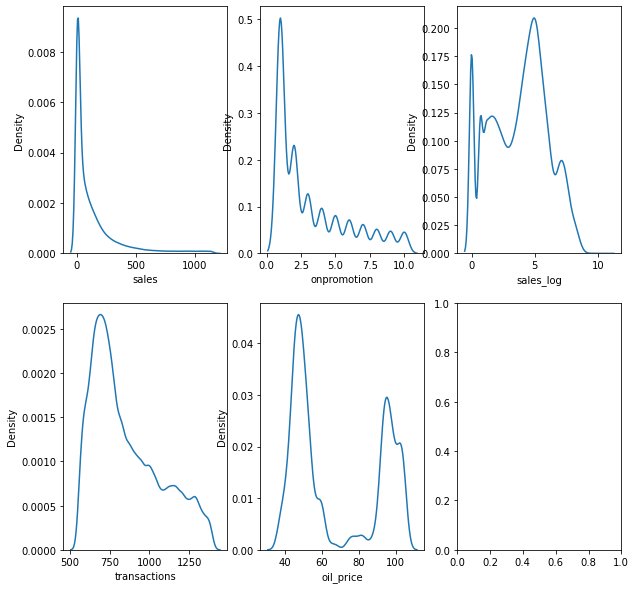

In [58]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for i in range(4):
    sns.kdeplot(df_ana_no_outlier.iloc[:, i], ax=ax[i//2, i%2])

sns.kdeplot(df_ana['sales_log'], ax=ax[0][2])
plt.show()


* There are significant outliers in sales, onpromotion
* 2 kurtosis distribution in oil_price are not normal distribution, consider to divide into 2 classes


<AxesSubplot:>

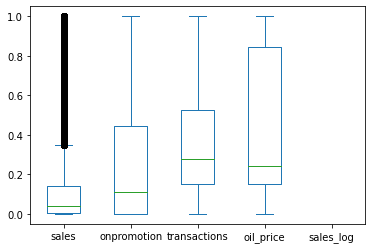

In [59]:
# normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_ana_norm = scaler.fit_transform(df_ana_no_outlier)
df_ana_norm = pd.DataFrame(df_ana_norm, columns=df_ana.columns)

df_ana_norm.plot(kind='box')

#### Bivariate Analysis

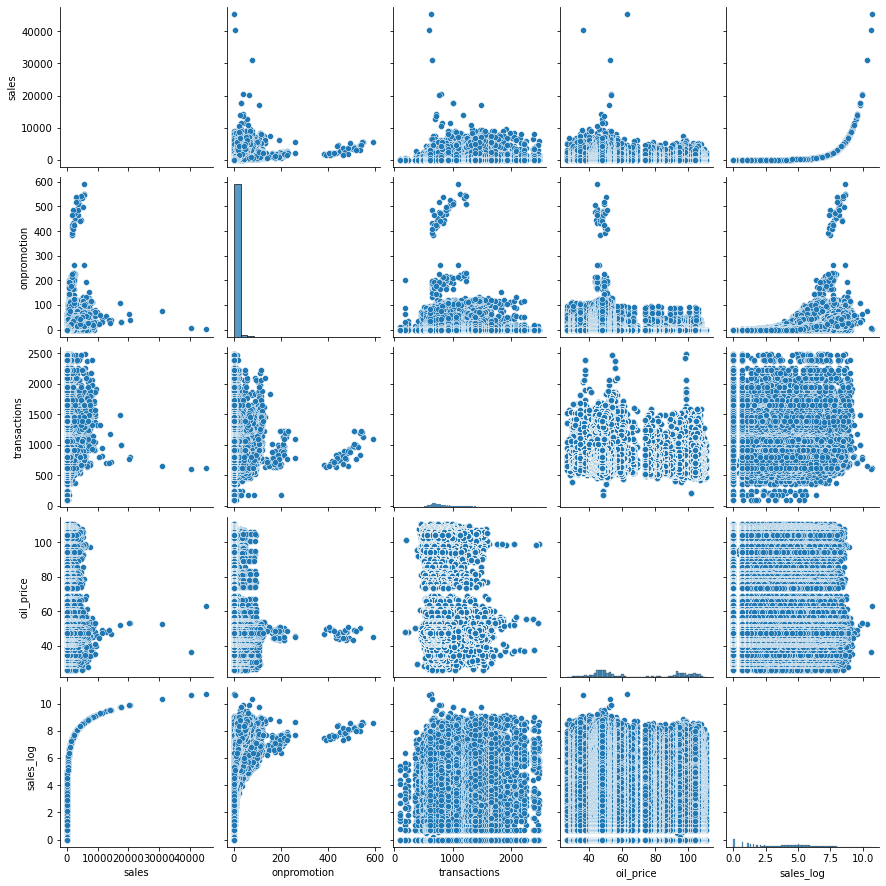

In [60]:
# pair-wise scatter plot
sns.pairplot(df_ana)

* high onpromotion seems to have a linear relationship with high sales

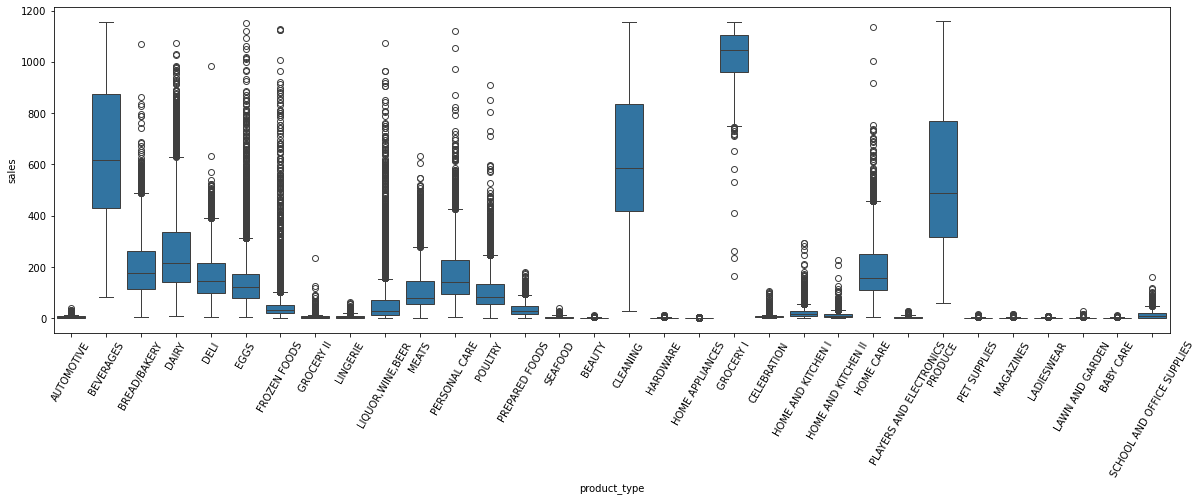

In [61]:
# categorical features distribution - product_type
df_plot = df_cluster_3[['product_type', 'sales']]
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.95)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]


fig = plt.figure(figsize=(20, 6))
sns.boxplot(x='product_type', y='sales', data=df_plot1)
plt.xticks(rotation=60)

plt.show()

AUTOMOTIVE, CLEANING, and PLAYERS AND ELECTRONICS PRODUCE have high sales in cluster 3

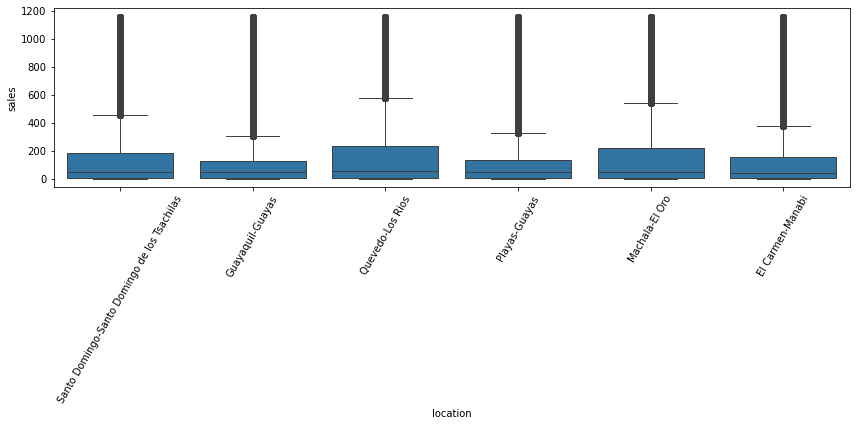

In [62]:
# categorical features distribution - city/state
df_plot = df_cluster_3[['sales', 'city', 'state']]
df_plot['location'] = df_plot['city'] + '-' + df_plot['state']
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.95)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]

fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y='sales', data=df_plot1)
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

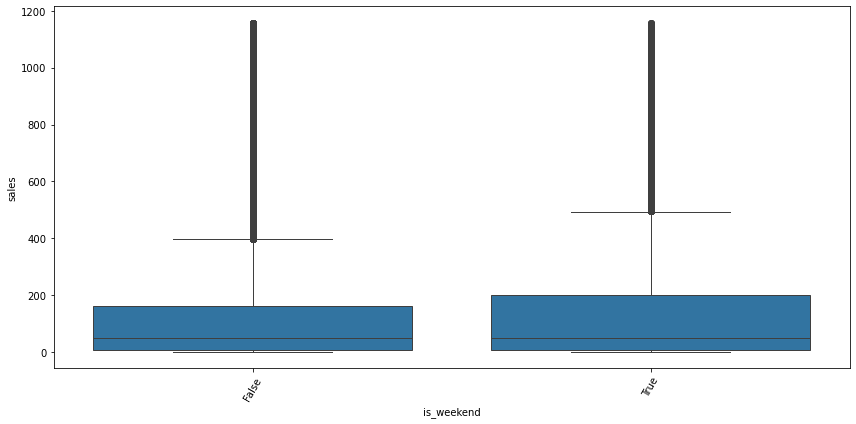

In [63]:
# weekend analysis
df_plot = df_cluster_3[['sales', 'is_weekend']]
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.95)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]

fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='is_weekend', y='sales', data=df_plot1)
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

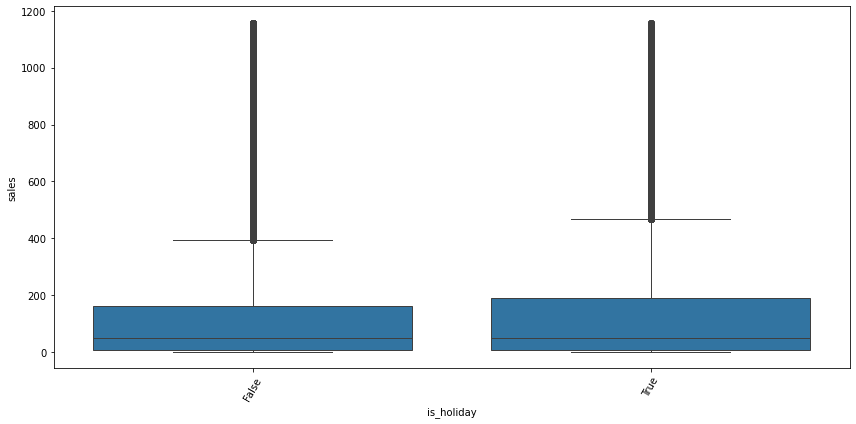

In [64]:
# holiday type analysis
df_plot = df_cluster_3[['sales', 'holiday_type']]
df_plot['is_holiday'] = df_plot['holiday_type'] != 'Work Day'
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.95)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]

fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='is_holiday', y='sales', data=df_plot1)
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

there is no significant difference between holiday and work day

#### Time Trend Analysis

<Figure size 864x432 with 0 Axes>

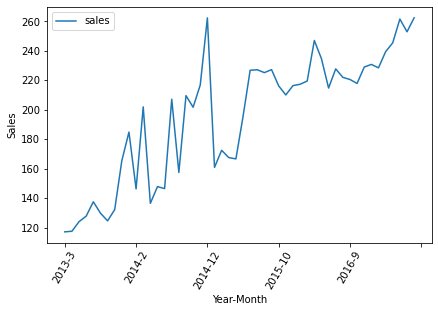

In [65]:
# time trend - monthly sales
df_plot = df_cluster_3[['sales', 'year', 'month']].groupby(['year', 'month'])['sales'].mean().reset_index().sort_values(by=['year', 'month'])
df_plot['year-month'] = df_plot['year'].astype(str) + '-' + df_plot['month'].astype(str)
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.95)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]

fig = plt.figure(figsize=(12, 6))
df_plot1.plot(kind='line', x='year-month', y='sales')
plt.tight_layout()
plt.xlabel('Year-Month')
plt.xticks(rotation=60)
plt.ylabel('Sales')

plt.show()


* **Growth**: significant growth from 2013 to 2017
* **Fluctuation**: very high fluctuation with sharp peaks and drops

/var/folders/_r/vj6nt35x41x_pn1g571_9tw80000gn/T/ipykernel_4624/3683150179.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


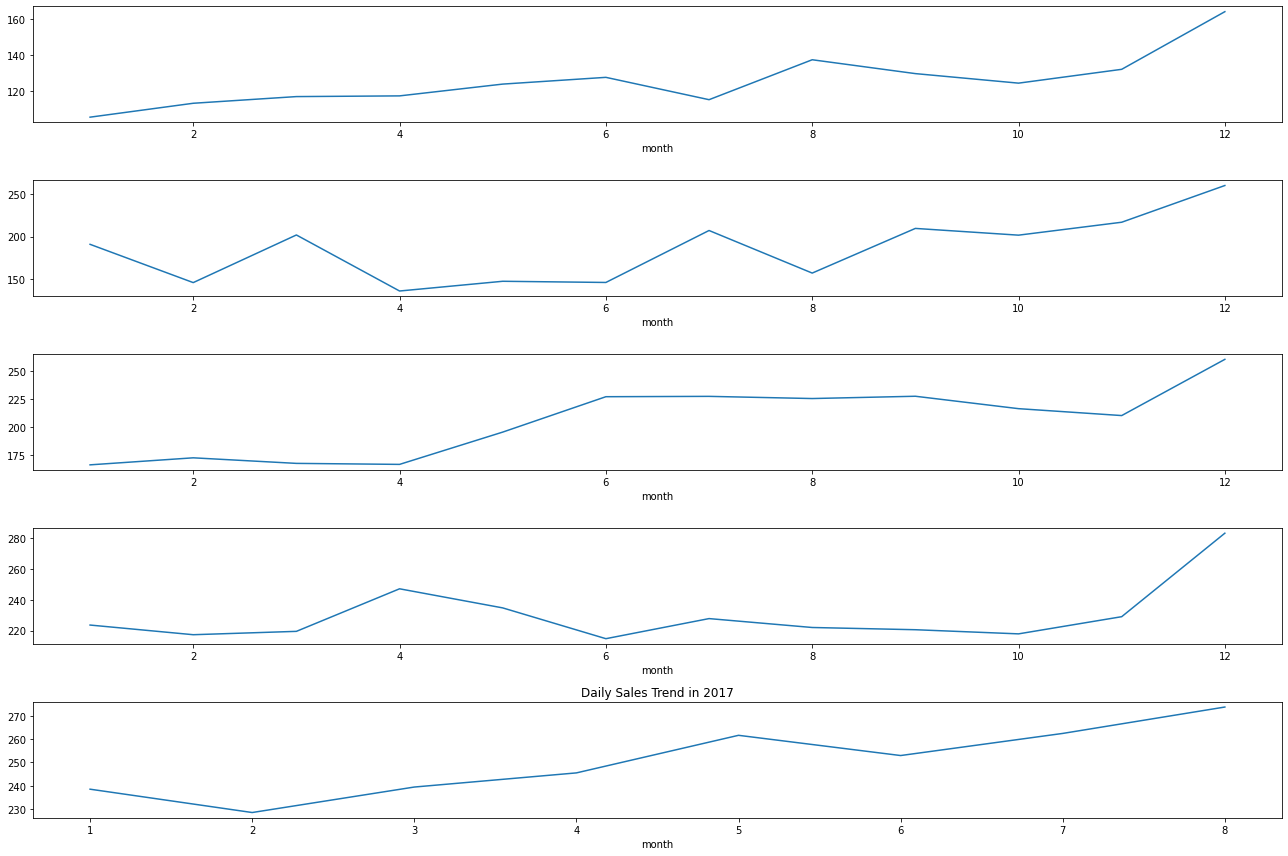

In [421]:
# time series trend analysis - monthly  sales
years = ['2013', '2014', '2015', '2016', '2017']
df_plots = [df_cluster_3[(df_cluster_3['date'] > f'{year}-01-01') & (df_cluster_3['date'] < f'{year}-12-31')] for year in years]
df_plot_dailies = [df.groupby('month')['sales'].mean() for df in df_plots]

fig, ax = plt.subplots(len(years), 1, figsize=(18, 12))

for i, df_plot_daily in enumerate(df_plot_dailies):
    df_plot_daily.plot(kind='line', ax=ax[i])
    plt.title(f'Daily Sales Trend in {years[i]}')

plt.tight_layout()

fig.show()


* Seasonality: Sales are low in the first half of the year and high in the second half. Every December has a spike.

/var/folders/_r/vj6nt35x41x_pn1g571_9tw80000gn/T/ipykernel_4624/3946990967.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


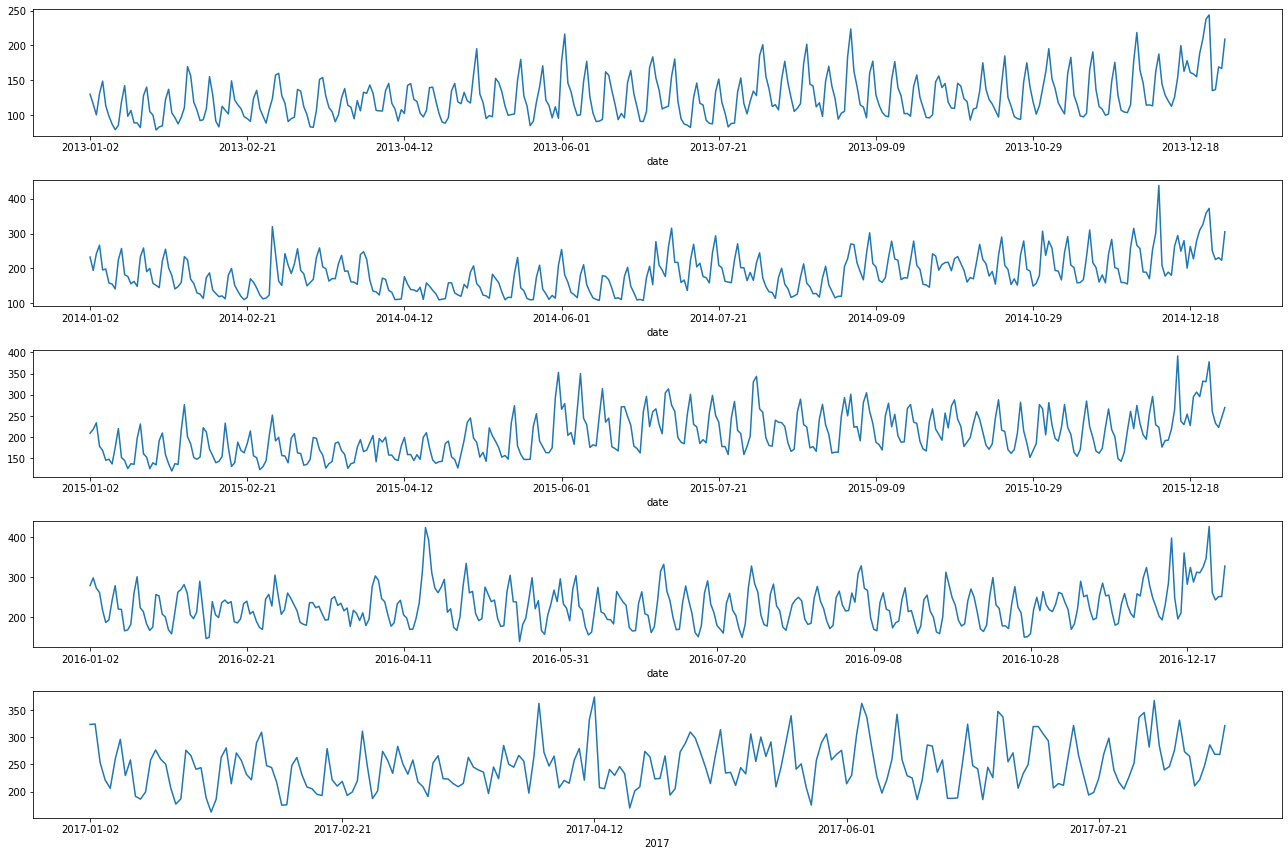

In [404]:
# time trend - daily sales
years = ['2013', '2014', '2015', '2016', '2017']
df_plots = [df_cluster_3[(df_cluster_3['date'] > f'{year}-01-01') & (df_cluster_3['date'] < f'{year}-12-31')] for year in years]
df_plot_daily = [df.groupby('date')['sales'].mean() for df in df_plots]

fig, ax = plt.subplots(len(years), 1, figsize=(18, 12))

for i, df_plot_daily in enumerate(df_plot_daily):
    df_plot_daily.plot(kind='line', ax=ax[i])
    plt.xlabel(years[i])

plt.tight_layout()

fig.show()


* Seasonality: very obvious weekly seasonality with a peak on Sunday.

/var/folders/_r/vj6nt35x41x_pn1g571_9tw80000gn/T/ipykernel_4624/3362091077.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


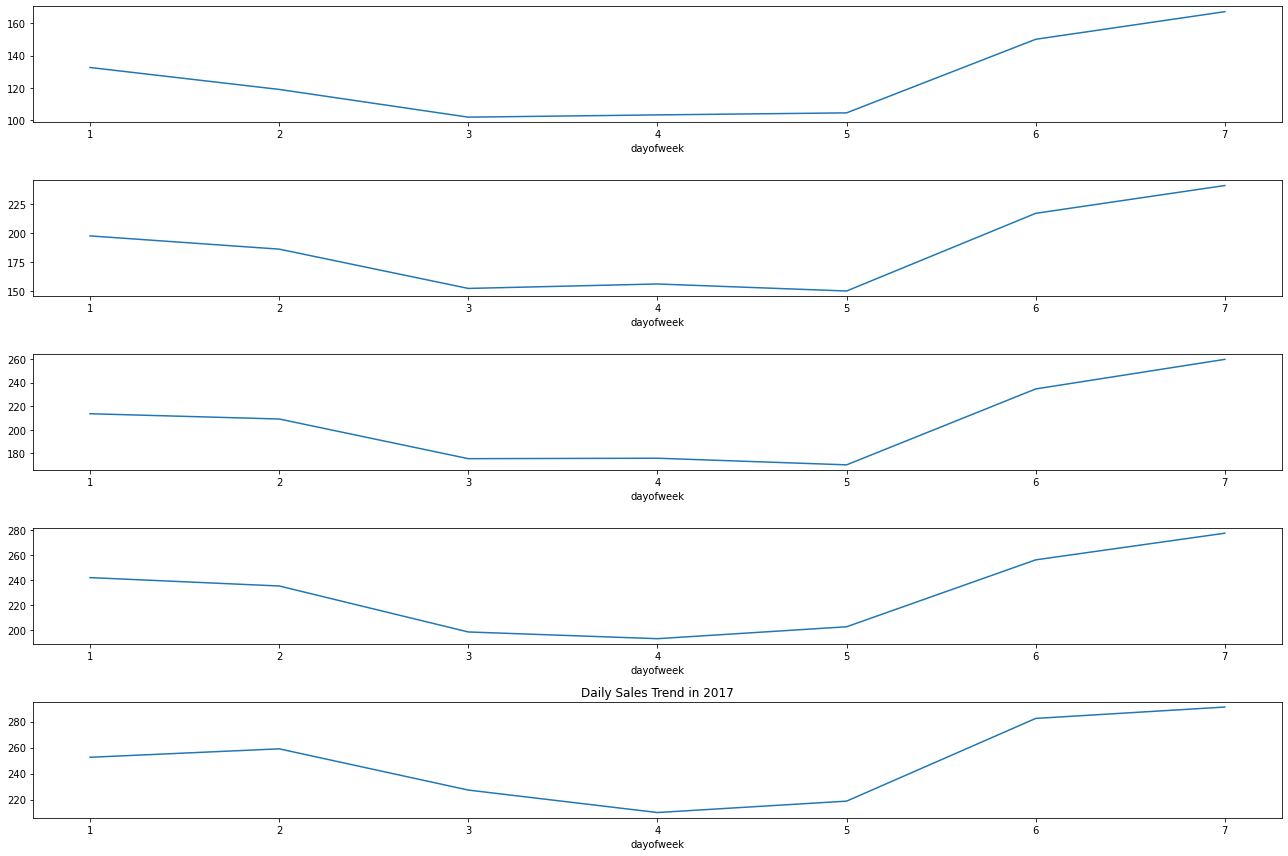

In [422]:
# time series trend analysis - weekly sales
years = ['2013', '2014', '2015', '2016', '2017']
df_plots = [df_cluster_3[(df_cluster_3['date'] > f'{year}-01-01') & (df_cluster_3['date'] < f'{year}-12-31')] for year in years]
df_plot_dailies = [df.groupby('dayofweek')['sales'].mean() for df in df_plots]

fig, ax = plt.subplots(len(years), 1, figsize=(18, 12))

for i, df_plot_daily in enumerate(df_plot_dailies):
    df_plot_daily.plot(kind='line', ax=ax[i])
    plt.title(f'Daily Sales Trend in {years[i]}')

plt.tight_layout()

fig.show()


* Seasonality: very obvious trend with increase since Saturday and peak on Sunday. While drop since Monday, and drop sharply from Wednesday to Friday.

### All clusters analysis in one year

In [91]:
# 2016 year data
df_clean = pd.read_csv('../data/train_processed.csv')

df_2016 = df_clean[df_clean['year'] == 2016]
df_2016.shape

(670032, 19)

In [6]:
df_2016.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
date,670032,365,2016-06-25,5346
product_type,670032,33,AUTOMOTIVE,20304
holiday_type,670032,7,Work Day,487575
city,670032,22,Quito,223344
state,670032,16,Pichincha,235752
store_type,670032,5,D,223344


In [7]:
df_ana = df_2016[['sales', 'onpromotion', 'transactions', 'oil_price']]

df_ana.describe().T\
.join(pd.DataFrame(df_ana.select_dtypes(include=['float64', 'int64', 'bool']).skew(), columns=['Skewness']))\
.join(pd.DataFrame(df_ana.select_dtypes(include=['float64', 'int64', 'bool']).kurtosis(), columns=['Kurtosis']))


,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis
sales,670032.0,446.518917,1306.049242,0.00,2.0,22.0,257.03625,124717.00,8.722756,290.616516
onpromotion,670032.0,5.402903,18.355118,0.00,0.0,0.0,2.00000,741.00,8.830715,163.738859
transactions,646173.0,1640.686278,949.751201,5.00,1002.0,1347.0,1976.00000,8307.00,1.615067,3.032211
oil_price,454410.0,43.340392,6.712095,26.19,39.5,45.2,48.48000,54.01,-0.777718,-0.384080


In [8]:
# remove outliers
df_ana_no_outlier = df_ana[(df_ana < df_ana.quantile(0.95)) & (df_ana > df_ana.quantile(0.05))]

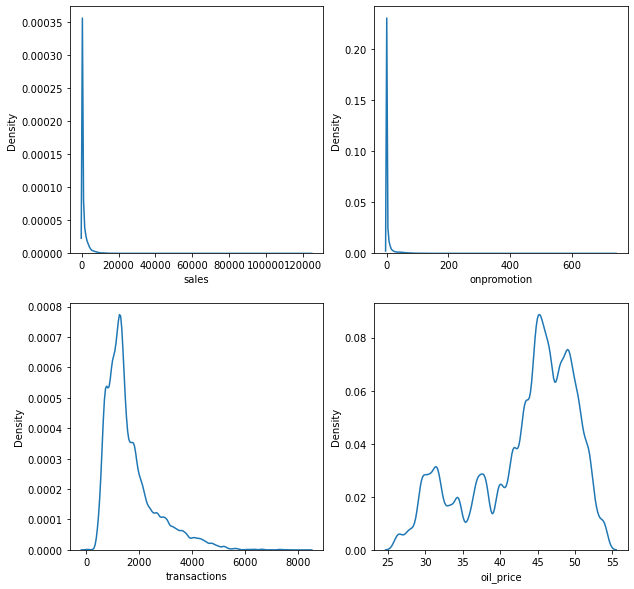

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    sns.kdeplot(df_ana.iloc[:, i], ax=ax[i//2, i%2])

plt.show()


<AxesSubplot:>

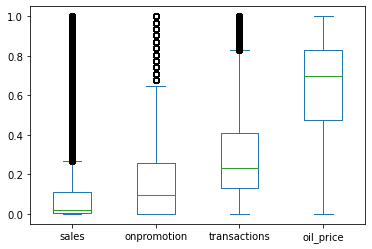

In [10]:
# normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_ana_norm = scaler.fit_transform(df_ana_no_outlier)
df_ana_norm = pd.DataFrame(df_ana_norm, columns=df_ana.columns)

df_ana_norm.plot(kind='box')

#### Bivariate Analysis

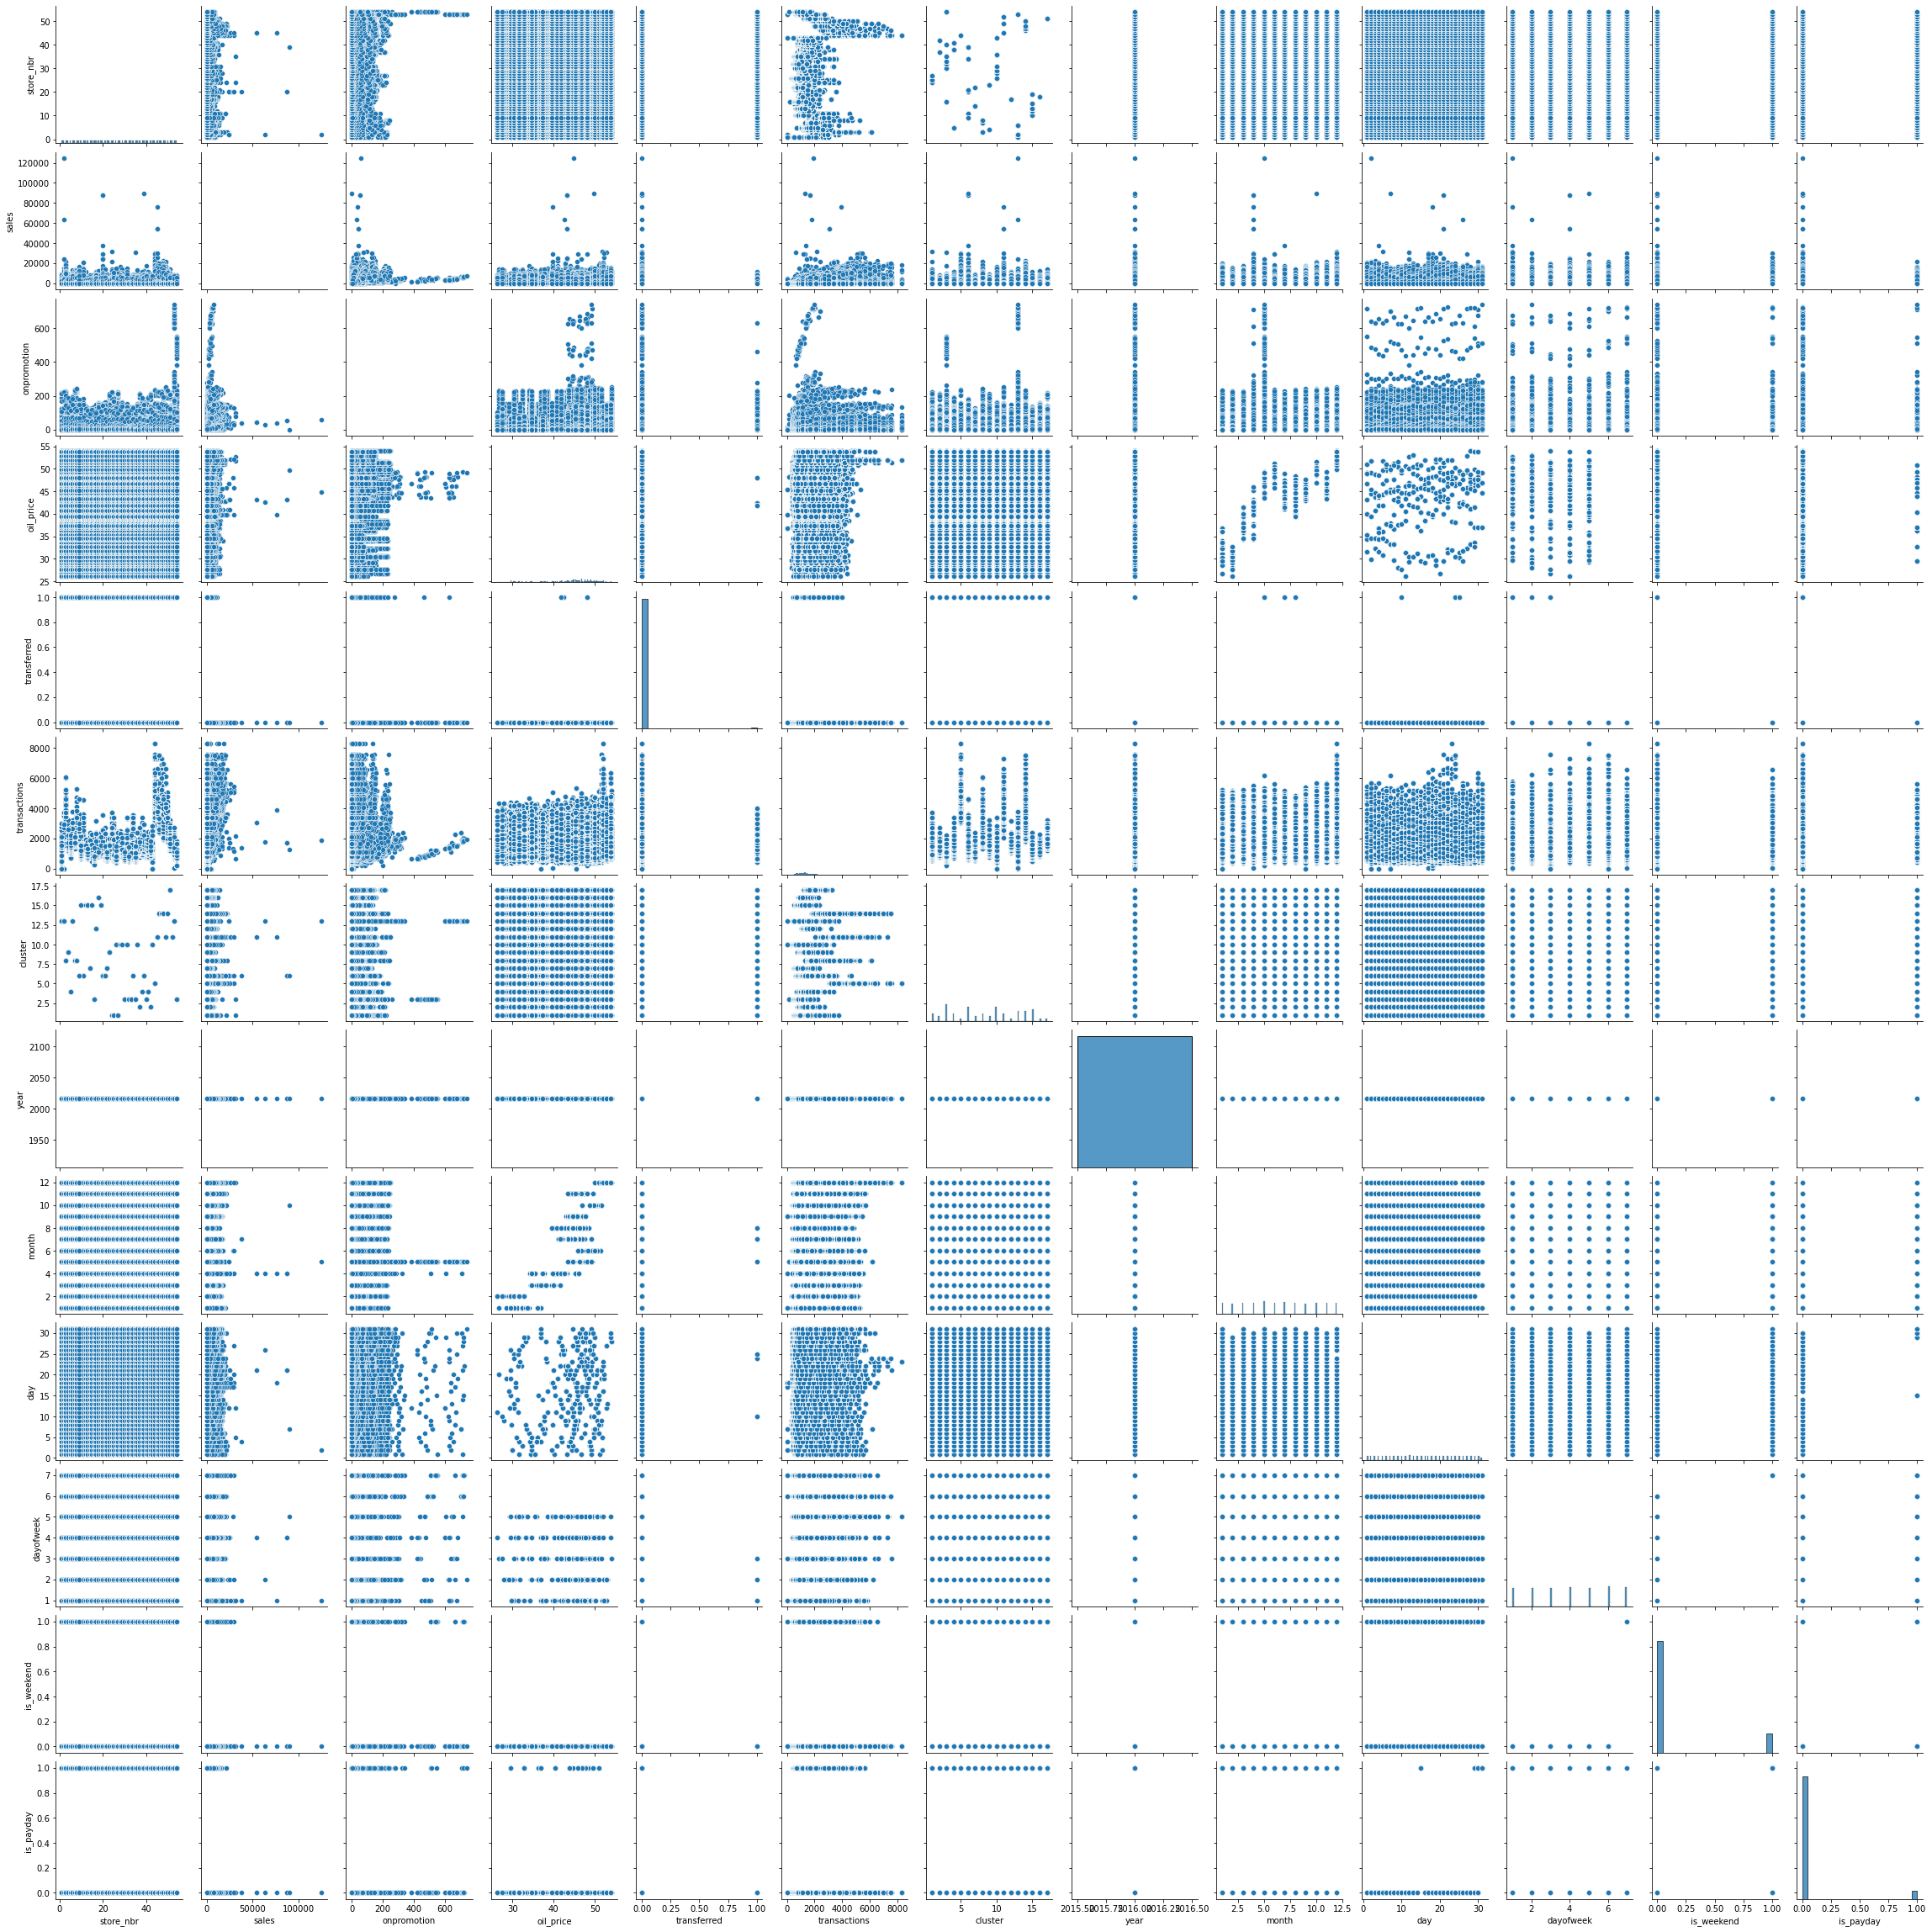

In [484]:
sns.pairplot(df_2016)

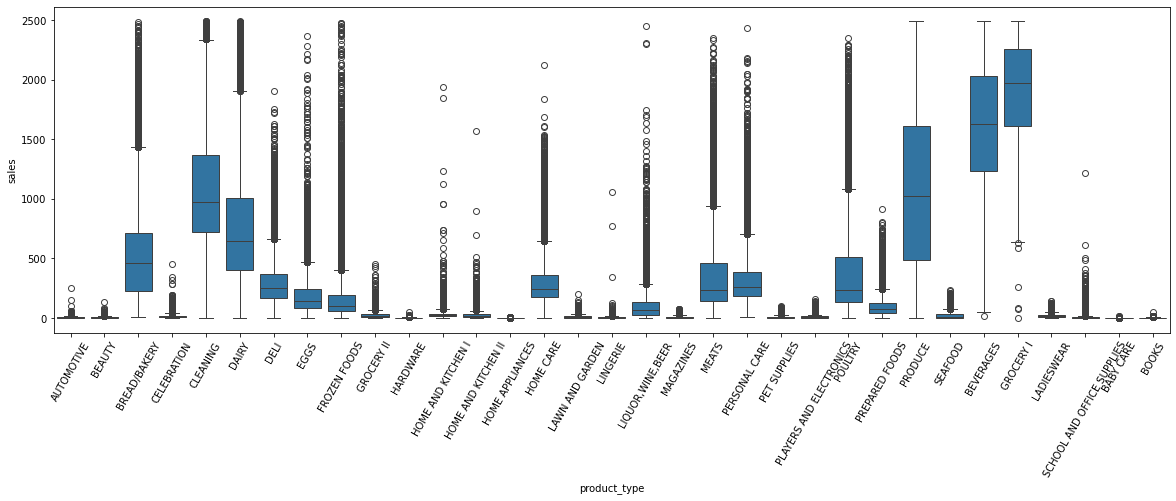

In [486]:
# categorical features distribution - product_type
df_plot = df_2016[['product_type', 'sales']]
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.95)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]


fig = plt.figure(figsize=(20, 6))
sns.boxplot(x='product_type', y='sales', data=df_plot1)
plt.xticks(rotation=60)

plt.show()


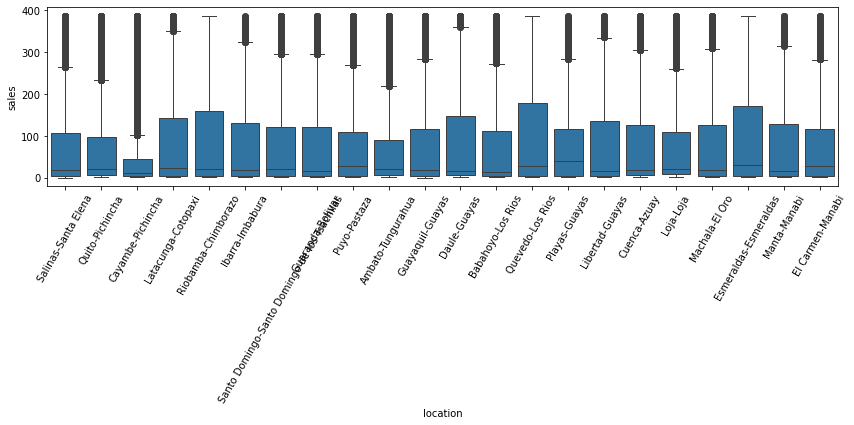

In [505]:
# categorical features distribution - city/state
df_plot = df_2016[['sales', 'city', 'state']]
df_plot['location'] = df_plot['city'] + '-' + df_plot['state']
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.8)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]

fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y='sales', data=df_plot1)
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

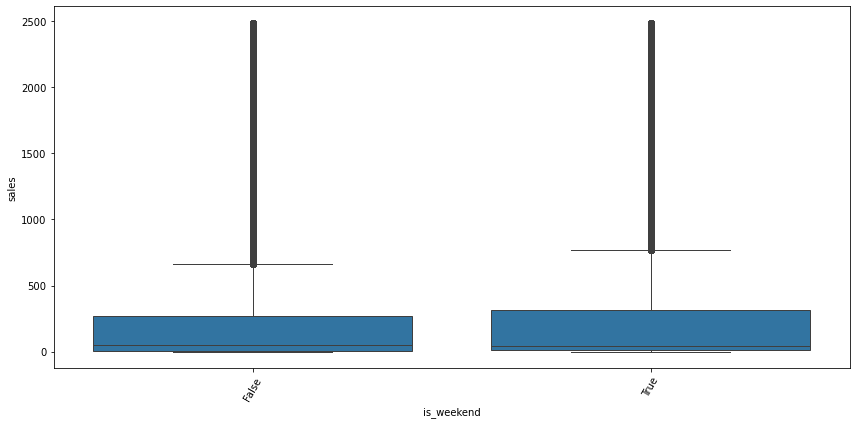

In [500]:
# weekend analysis
df_plot = df_2016[['sales', 'is_weekend']]
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.95)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]

fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='is_weekend', y='sales', data=df_plot1)
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

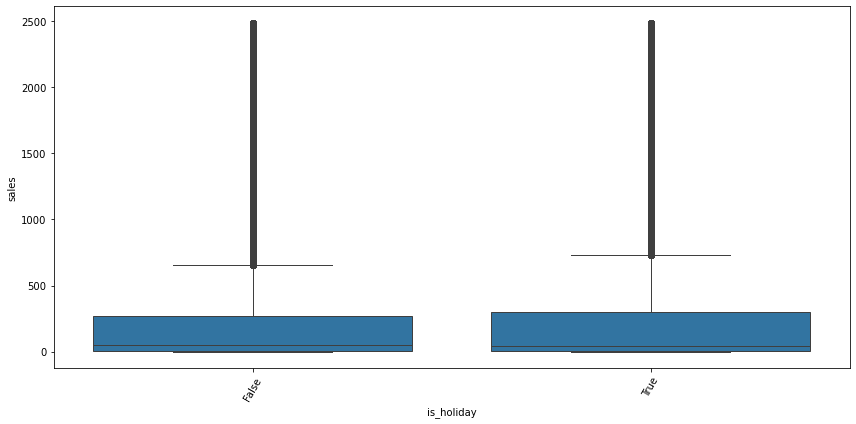

In [502]:
# holiday type analysis
df_plot = df_2016[['sales', 'holiday_type']]
df_plot['is_holiday'] = df_plot['holiday_type'] != 'Work Day'
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.95)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]

fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='is_holiday', y='sales', data=df_plot1)
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

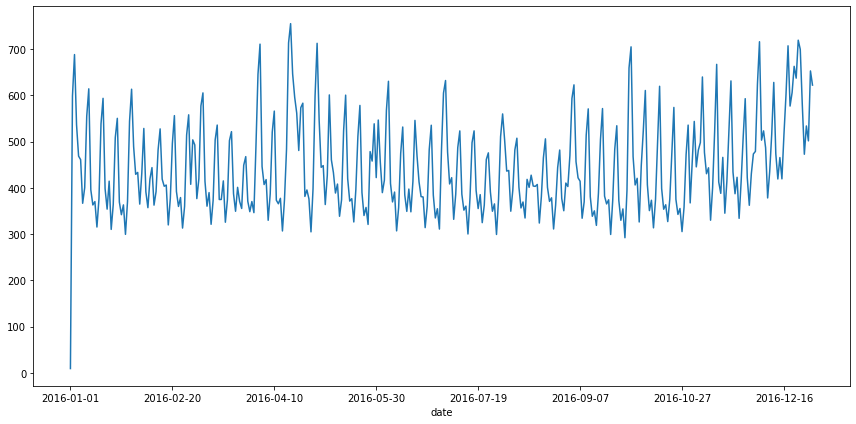

In [44]:
# time trend - daily sales
df_plot_daily = df_2016.groupby('date')['sales'].mean()

fig = plt.figure(figsize=(12, 6))
df_plot_daily.plot(kind='line')
plt.tight_layout()

fig.show()


most of All cluster data has no significant difference conclusions from cluster 3 analysis, except for :
* product_type: all clusters are different from cluster 3 high sale products
* location: all clusters are different from cluster 3 high sale locations

Not consider to use single cluster analysis for training or sampling

### All clusters all years

In [80]:
df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
product_type,3054348,33,AUTOMOTIVE,92556
holiday_type,3054348,7,Work Day,2387088
city,3054348,22,Quito,1018116
state,3054348,16,Pichincha,1074678
store_type,3054348,5,D,1018116


In [81]:
df_ana = df[['sales', 'onpromotion', 'transactions', 'oil_price']]

df_ana.describe().T\
.join(pd.DataFrame(df_ana.select_dtypes(include=['float64', 'int64', 'bool']).skew(), columns=['Skewness']))\
.join(pd.DataFrame(df_ana.select_dtypes(include=['float64', 'int64', 'bool']).kurtosis(), columns=['Kurtosis']))


,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis
sales,3054348.0,359.020892,1107.285897,0.00,0.00,11.00,196.011,124717.00,7.499912,165.068445
onpromotion,3054348.0,2.617480,12.254939,0.00,0.00,0.00,0.000,741.00,11.299618,250.886389
transactions,2805231.0,1697.071441,966.831652,5.00,1046.00,1395.00,2081.000,8359.00,1.530068,2.640394
oil_price,2099196.0,68.015874,25.691342,26.19,46.41,53.43,95.810,110.62,0.300234,-1.622873


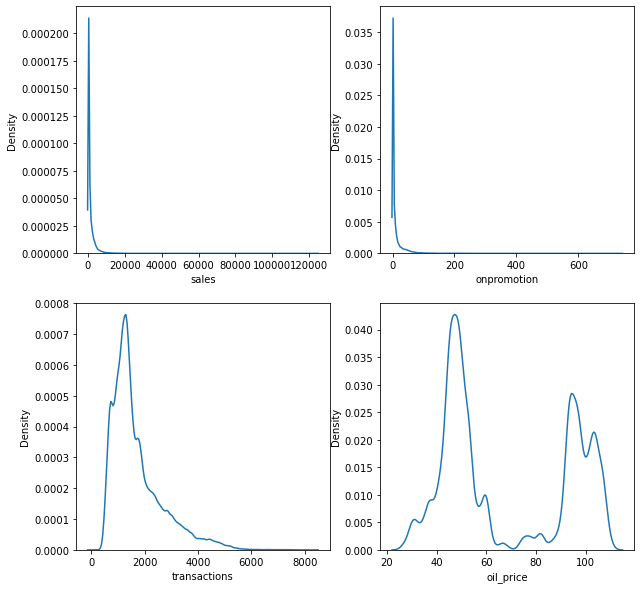

In [82]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    sns.kdeplot(df_ana.iloc[:, i], ax=ax[i//2, i%2])

plt.show()


<AxesSubplot:>

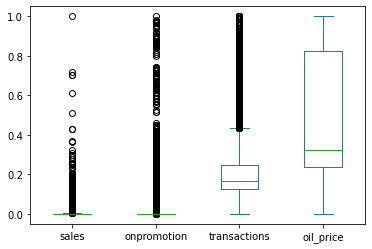

In [86]:
# normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_ana_norm = scaler.fit_transform(df_ana)
df_ana_norm = pd.DataFrame(df_ana_norm, columns=df_ana.columns)

df_ana_norm.plot(kind='box')

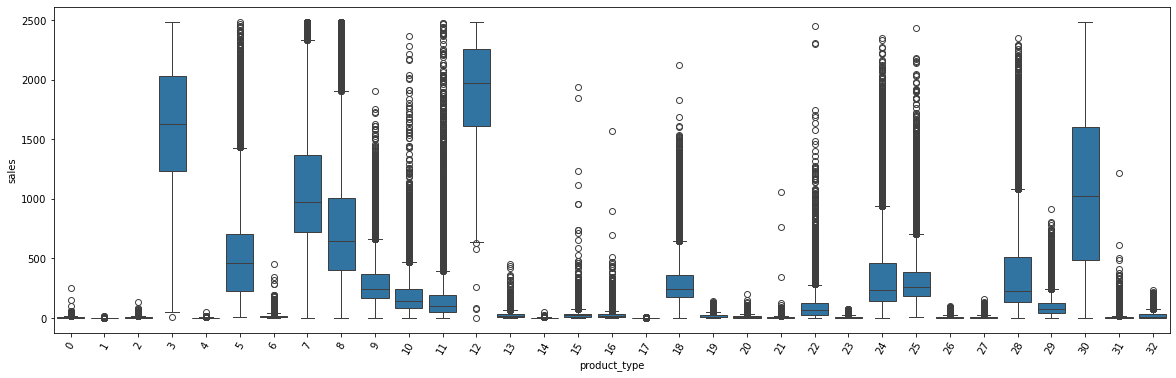

In [85]:
# categorical features distribution - product_type
df_plot = df_2016[['product_type', 'sales']]
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.95)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]


fig = plt.figure(figsize=(20, 6))
sns.boxplot(x='product_type', y='sales', data=df_plot1)
plt.xticks(rotation=60)

plt.show()


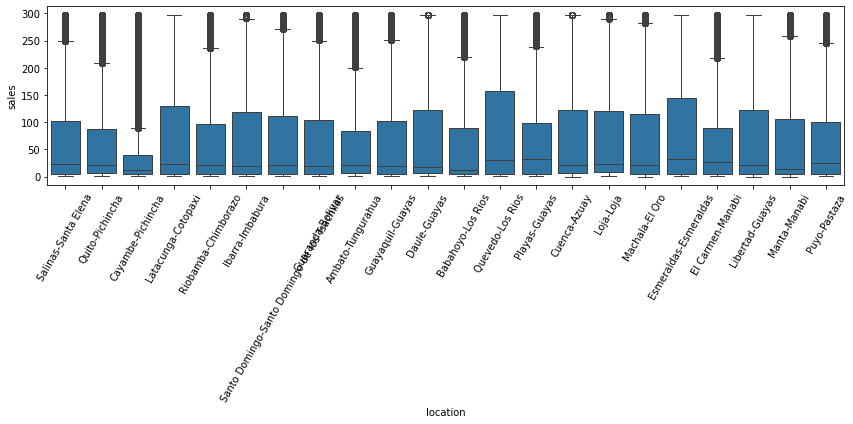

In [88]:
# categorical features distribution - city/state
df_plot = df[['sales', 'city', 'state']]
df_plot['location'] = df_plot['city'] + '-' + df_plot['state']
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.8)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]

fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y='sales', data=df_plot1)
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

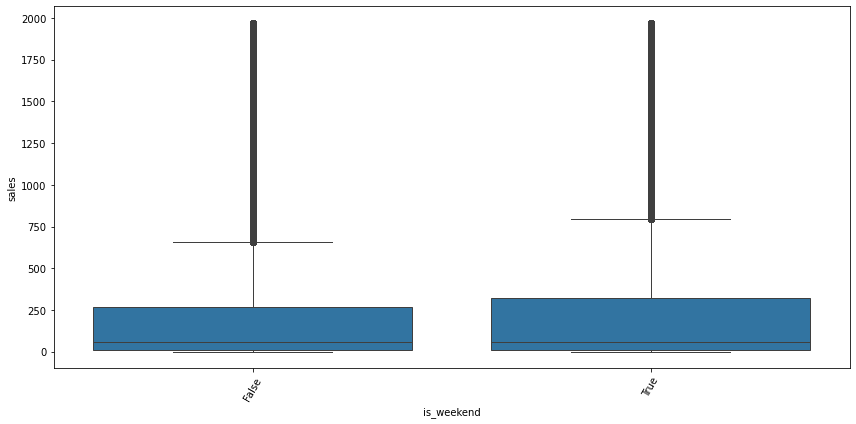

In [89]:
# weekend analysis
df_plot = df[['sales', 'is_weekend']]
df_plot1 = df_plot[(df_plot['sales'] < df_plot['sales'].quantile(0.95)) & (df_plot['sales'] > df_plot['sales'].quantile(0.05))]

fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='is_weekend', y='sales', data=df_plot1)
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

<Figure size 864x432 with 0 Axes>

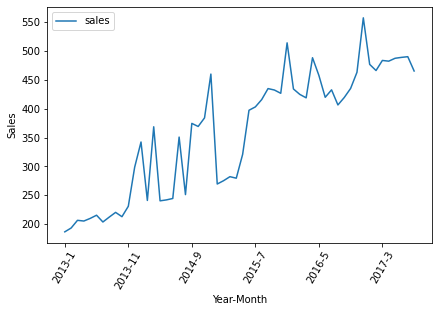

In [74]:
# time trend - monthly sales
df_plot = df[['sales', 'year', 'month']].groupby(['year', 'month'])['sales'].mean().reset_index().sort_values(by=['year', 'month'])
df_plot['year-month'] = df_plot['year'].astype(str) + '-' + df_plot['month'].astype(str)

fig = plt.figure(figsize=(12, 6))
df_plot.plot(kind='line', x='year-month', y='sales')
plt.tight_layout()
plt.xlabel('Year-Month')
plt.xticks(rotation=60)
plt.ylabel('Sales')

plt.show()


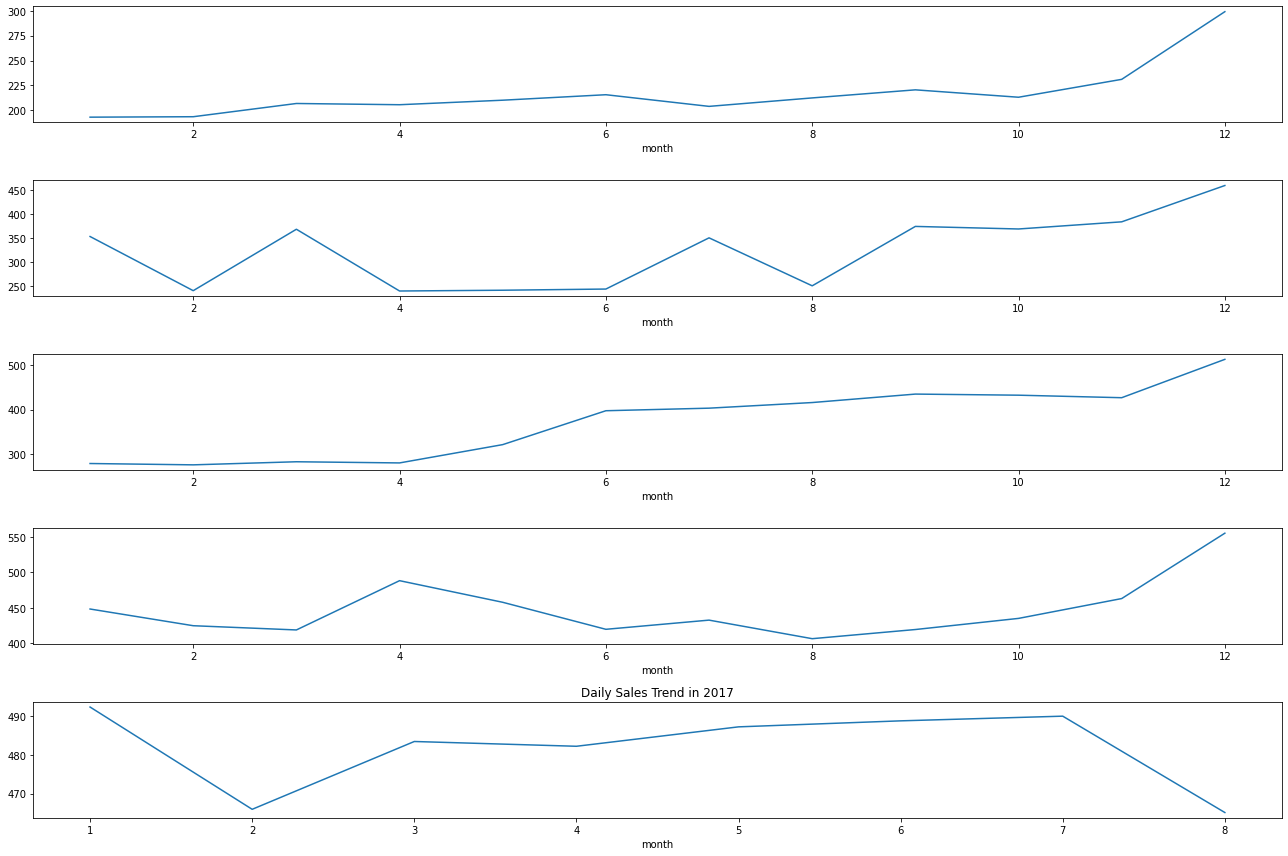

In [76]:
# time series trend analysis - monthly  sales
years = ['2013', '2014', '2015', '2016', '2017']
df_plots = [df[(df['date'] > f'{year}-01-01') & (df['date'] < f'{year}-12-31')] for year in years]
df_plot_dailies = [df.groupby('month')['sales'].mean() for df in df_plots]

fig, ax = plt.subplots(len(years), 1, figsize=(18, 12))

for i, df_plot_daily in enumerate(df_plot_dailies):
    df_plot_daily.plot(kind='line', ax=ax[i])
    plt.title(f'Daily Sales Trend in {years[i]}')

plt.tight_layout()

fig.show()

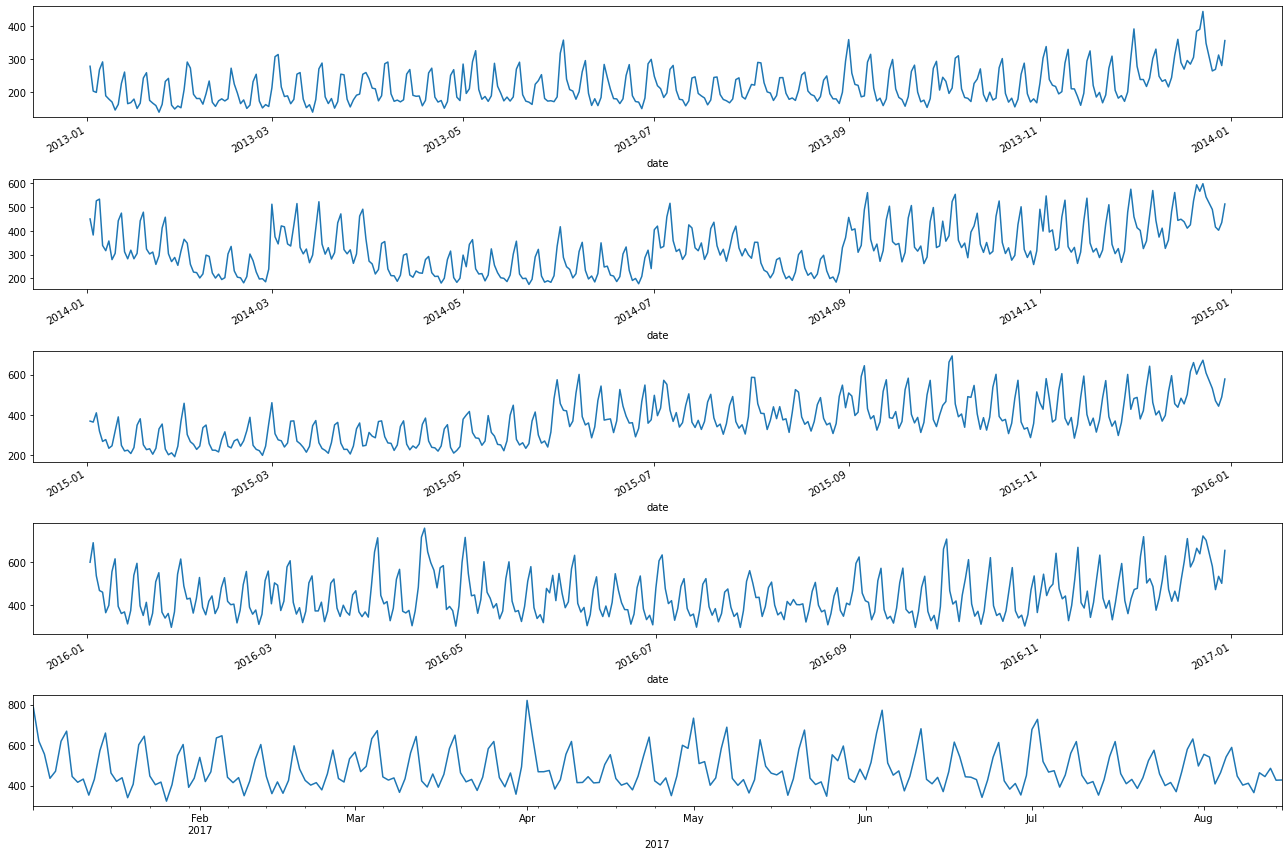

In [77]:
# time trend - daily sales
years = ['2013', '2014', '2015', '2016', '2017']
df_plots = [df[(df['date'] > f'{year}-01-01') & (df['date'] < f'{year}-12-31')] for year in years]
df_plot_daily = [df.groupby('date')['sales'].mean() for df in df_plots]

fig, ax = plt.subplots(len(years), 1, figsize=(18, 12))

for i, df_plot_daily in enumerate(df_plot_daily):
    df_plot_daily.plot(kind='line', ax=ax[i])
    plt.xlabel(years[i])

plt.tight_layout()

fig.show()


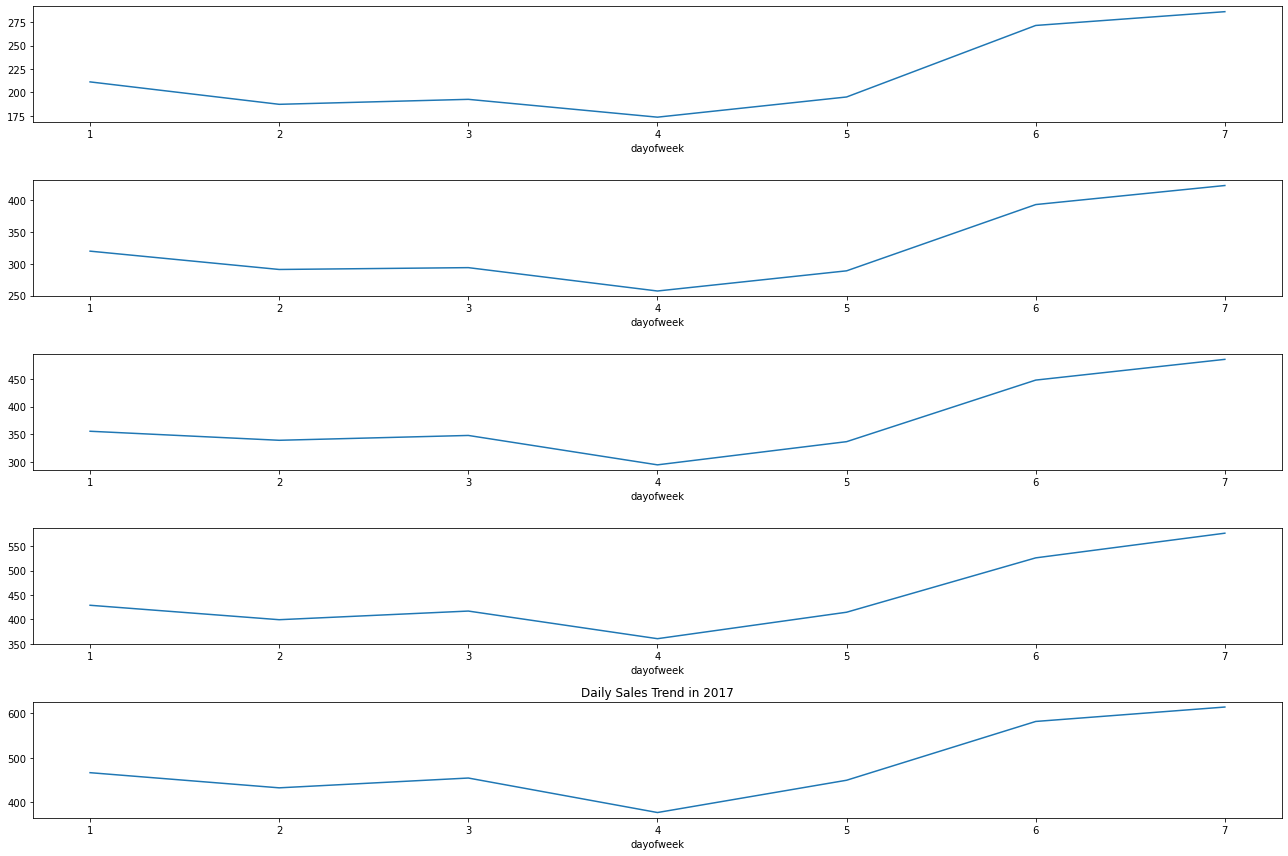

In [78]:
# time series trend analysis - weekly sales
years = ['2013', '2014', '2015', '2016', '2017']
df_plots = [df[(df['date'] > f'{year}-01-01') & (df['date'] < f'{year}-12-31')] for year in years]
df_plot_dailies = [df.groupby('dayofweek')['sales'].mean() for df in df_plots]

fig, ax = plt.subplots(len(years), 1, figsize=(18, 12))

for i, df_plot_daily in enumerate(df_plot_dailies):
    df_plot_daily.plot(kind='line', ax=ax[i])
    plt.title(f'Daily Sales Trend in {years[i]}')

plt.tight_layout()

fig.show()


### Conclusion

From all clusters all years analysis, we can get the following conclusions:

#### Distribution
**Numerical Features**: 

* **Sales**: There are significant outliers both in single cluster, single year, and population data.
* **Onpromotion**: Same as sales, but less severe.
* **Oil_price**: There are 2 kurtosis distribution in oil_price, can consider to divide into 2 classes in optimization. in all years and single cluster
  * **NOTE**: In single year 2016, there is no kurtosis distribution.

**Categorical Features**: no significant difference

#### Bins
* **Product_type**: classification of sales in all years is different from single cluster and single.
  * Not consider to bin in all years forecasting. Consider later while optimizing the training.
Same as city, state, and working day/holiday(no siginifcant difference in all analysis)

#### Time Trend (same trend in all analysis)
* **Growth**: significant growth from 2013 to 2017
* **Seasonality**: 
  * **Monthly**: Sales are low in the first half of the year and high in the second half. Every December has a spike.
  * **Weekly**: very obvious weekly seasonality with increasing since Saturday and a peak on Sunday. While drop since Monday, and drop sharply from Wednesday to Friday.
* **Fluctuation**: very high fluctuation with sharp peaks and drops

#### Conclusion
* Benchmark and Optimization dataset:
1. For benchmark model, using 2016 dataset with sales for ARIMA training.
2. For optimization, using 2016 dataset with features with machine learning models (LSTM, XGBoost, etc.).
3. Using 2017 as test dataset.

* Further optimization methods:
1. add more historical years as training dataset
2. Consider to add specific binning methods on product type feature for each cluster
3. Binning oil_price feature into 2 classes
4. Try more outlier methods on sales and onpromotion features
5. Add window size feature for holiday and non-holiday
6. Analysis more on cluster classification

### Feature Engineering

From statistical analysis, we can try some feature engineering to improve the model performance.


In [3]:
# 2016 year data
df_clean = pd.read_csv('../data/train_processed.csv')

df_2016 = df_clean[df_clean['year'] == 2016]
df_2016.shape

(670032, 19)

In [4]:
# encode categorical features
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_2016['product_type'] = encoder.fit_transform(df_2016['product_type'])
df_2016['store_type'] = encoder.fit_transform(df_2016['store_type'])
df_2016['city'] = encoder.fit_transform(df_2016['city'])
df_2016['state'] = encoder.fit_transform(df_2016['state'])

df_2016['is_holiday'] = (df_2016['holiday_type'] != 'Work Day').astype(int)
df_2016['is_weekend'] = df_2016['is_weekend'].astype(int)
df_2016['is_payday'] = df_2016['is_payday'].astype(int)

df_train_2016 = df_2016.drop(columns=['holiday_type', 'transferred'], axis=1)

# process missing values with forward fill
df_train_2016.fillna(method='ffill', inplace=True)

# Get training dataset
df_train_2016 = df_train_2016.dropna()

# Optimize outlier removal for 'sales' and 'onpromotion' using z-score
def remove_outliers(df, column, z_score=3):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - z_score * std
    upper_bound = mean + z_score * std
    return df[(df[column] > lower_bound) & (df[column] < upper_bound)]

df_train_2016 = remove_outliers(df_train_2016, 'sales')
df_train_2016 = remove_outliers(df_train_2016, 'onpromotion')

df_train_2016 = df_train_2016.set_index('date')
df_train_2016.shape


(636833, 17)

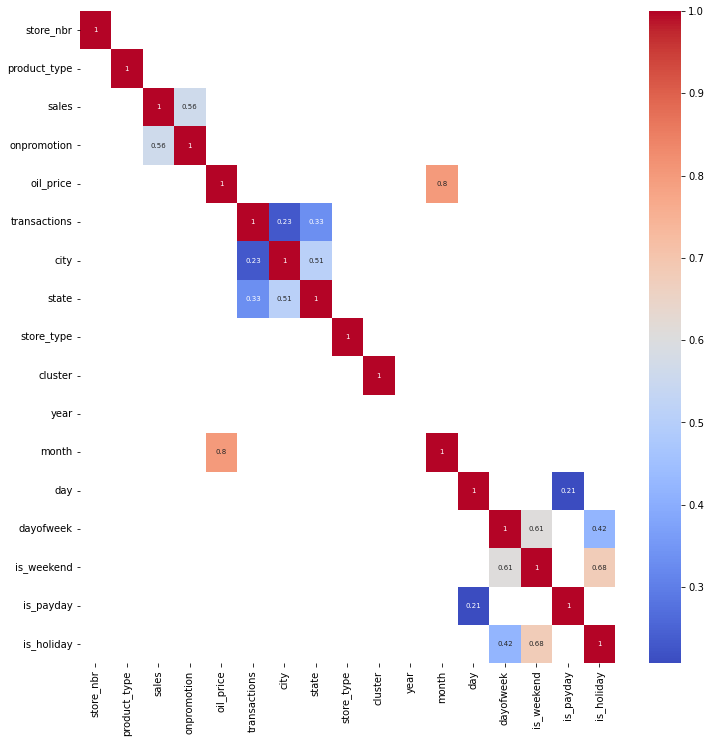

In [120]:
# linear correlation matrix - not display correlation less than 0.5 in heatmap
df_corr = df_train_2016.corr()
df_plot = df_corr[df_corr > 0.2]

fig = plt.figure(figsize=(12, 12))
sns.heatmap(df_plot, annot=True, cmap='coolwarm', annot_kws={'size': 7})
plt.show()

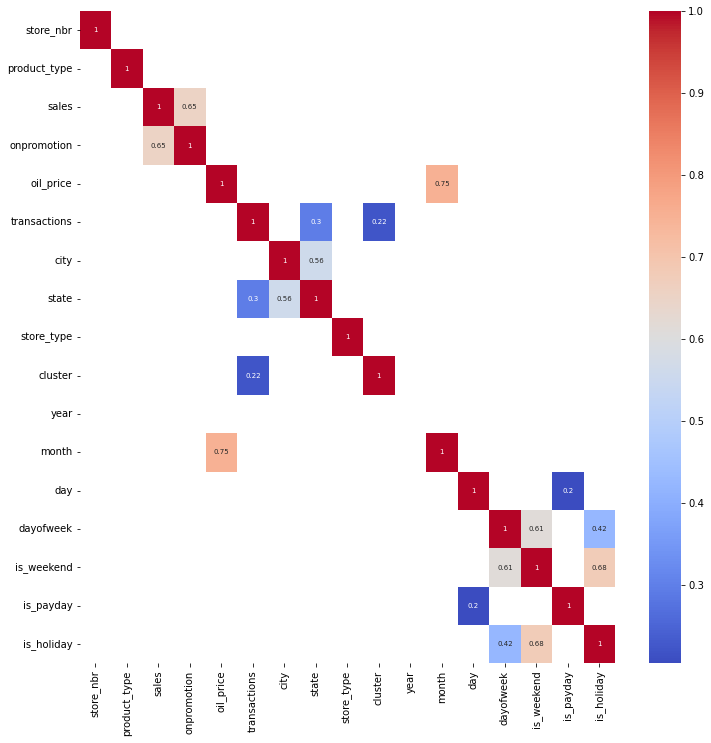

In [122]:
# non-linear correlation matrix - not display correlation less than 0.5 in heatmap
df_corr = df_train_2016.corr(method='spearman')
df_plot = df_corr[df_corr > 0.2]

fig = plt.figure(figsize=(12, 12))
sns.heatmap(df_plot, annot=True, cmap='coolwarm', annot_kws={'size': 7})
plt.show()


In [10]:
df_train_csv = df_train_2016[['year','month', 'day', 'dayofweek', 'is_weekend', 'is_payday', 'is_holiday',
                               'store_nbr', 'city', 'state', 'store_type', 'cluster', 
                               'product_type', 'onpromotion', 'oil_price', 'transactions', 'sales', ]]
df_train_csv.to_csv('../data/train_2016.csv', index=True)
